# RED NEURONAL.

El armado de esta red neuronal pretende predecir la siguiente nota.

La base de datos elegida es un conjunto de datos que contiene alrededor de 200hs de grabaciones de audio y MIDI emparejadas de diez años de Concurso Internacional de Piano.

FUENTE: https://magenta.tensorflow.org/datasets/maestro

In [1]:
# import zipfile as zf
# files = zf.ZipFile("/content/maestro-v3.0.0-midi.zip", 'r')
# files.extractall('data/')
# files.close()
!pip install pretty_midi
!pip install tensorflow
!pip install scikit-learn

Se instalan todos los paquetes relevantes para procesar y escuchar archivos MIDI, glob para iterar sobre los archivos del dataset, collections para el diccionario con valor por defecto, y pathlib para abrir el archivo.

In [2]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import tensorflow as tf
import itertools
import matplotlib
from sklearn.model_selection import train_test_split

Se define un directorio que contendra todos los archivos MIDI que seran analizados. Se arma una funcion que convierte esos archivos a un DataFrame de pandas donde utilizamos una variable para definir una "nota" que contendra como caracteristica el tono (pitch). Tono es la calidad sonora de la nota, lo que la distingue de otras.

In [3]:
np.random.seed(0)
directorio = pathlib.Path('data/maestro-v2.0.0')
if not directorio.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

filenames = glob.glob(str(directorio/'**/*.mid*'))
print('num archivos:', len(filenames))

# sample_file = "/content/MIDI-Unprocessed_25_R2_2011_MID--AUDIO_R2-D6_07_Track07_wav.midi"
# print(sample_file)

def midi_a_notas(midifile: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midifile)
    instrumento = pm.instruments[0]
    notas = collections.defaultdict(list)

    notas_orden = sorted(instrumento.notes, key=lambda nota: nota.start)
    previa_inicio = notas_orden[0].start

    for nota in notas_orden:
        notas['pitch'].append(nota.pitch)

    return pd.DataFrame({nombre: np.array(valor) for nombre, valor in notas.items()})

num archivos: 1282


Se agrega un fragmento de codigo hecho por otra persona, que permite escribir un dataframe con notas en un archivo midi y lo devuelve como prettyMIDI para poder escucharlo (No se usa):

In [4]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Se procesan los archivos MIDI, se extraen las notas de cada archivo y se preparan los datos para el modelo del aprendizaje automatico mas adelante.

In [5]:
notasGlobal = []
tam_muestra = 10

for f in filenames[:tam_muestra]:
  notas = midi_a_notas(f)
  notasGlobal.append(notas)

notasGlobal = pd.concat(notasGlobal)
print(notasGlobal.head())
num_notas = len(notasGlobal)

indice_notas = ['pitch']
notas_entrenamiento = np.array([notasGlobal[key] for key in indice_notas]).flatten()
np.set_printoptions(precision=3)
dataset_nota = tf.data.Dataset.from_tensor_slices(notas_entrenamiento)
print(num_notas)
#print(list(dataset_nota.as_numpy_iterator()))

   pitch
0     57
1     53
2     50
3     57
4     53
47022


Luego, transformamos el dataset de las notas en ventanas de secuencias para su uso.

In [6]:
def ventanizar(dataset, tam_ventana, alfabeto_notas = 128,) -> tf.data.Dataset:
  tam_ventana = tam_ventana + 1

  windows = dataset.window(tam_ventana, shift=1, stride=1, drop_remainder=True)
  flatten = lambda x: x.batch(tam_ventana, drop_remainder=True)
  sequences = windows.flat_map(flatten)


  # Normalize tono de las notas
  def normalizar_tono(x):
    x = x/tam_ventana
    return x

  # Partimos los indices
  def partir_indices(sequences):
    inputs = sequences[:-1]
    outputs_dense = sequences[-1]
    output = {'pitch':outputs_dense}
    return normalizar_tono(inputs), output
  return sequences.map(partir_indices,num_parallel_calls=tf.data.AUTOTUNE)

ventanitas = ventanizar(dataset_nota, 100)
dataset_pandas = pd.DataFrame(list(ventanitas.as_numpy_iterator()), columns=['inputs','output'])
dataset_pandas.head()


,inputs,output
0,"[0.5643564356435643, 0.5247524752475248, 0.495...",{'pitch': 50}
1,"[0.5247524752475248, 0.49504950495049505, 0.56...",{'pitch': 64}
2,"[0.49504950495049505, 0.5643564356435643, 0.52...",{'pitch': 58}
3,"[0.5643564356435643, 0.5247524752475248, 0.495...",{'pitch': 55}
4,"[0.5247524752475248, 0.49504950495049505, 0.63...",{'pitch': 50}


In [7]:
ventanitas.element_spec
for seq, target in ventanitas.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100,)
sequence elements (first 10): tf.Tensor([0.564 0.525 0.495 0.564 0.525 0.495 0.634 0.574 0.545 0.495], shape=(10,), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=int64, numpy=50>}


In [8]:
batch_size = 100
buffer_size = num_notas - 100  # tamaño ventana
dataset_train = (ventanitas
                .shuffle(buffer_size)
                .batch(batch_size, drop_remainder=True)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))
inputs = tf.keras.Input((100,1))
hidden = tf.keras.layers.Dense(60, name= 'hidden')(inputs)
output = tf.keras.layers.Dense(1, name='pitch')(hidden)

dataset_train.element_spec

(TensorSpec(shape=(100, 100), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(100,), dtype=tf.int64, name=None)})

In [9]:
model = tf.keras.Model(inputs, output)
loss = {'pitch': tf.keras.losses.MeanSquaredError()}
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 hidden (Dense)              (None, 100, 60)           120       
                                                                 
 pitch (Dense)               (None, 100, 1)            61        
                                                                 
Total params: 181 (724.00 Byte)
Trainable params: 181 (724.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
losses = model.evaluate(dataset_train, return_dict=True)
losses

469/469 [==============================] - 15s 10ms/step - loss: 4201.1963 - acc: 0.0000e+00


{'loss': 4201.1962890625, 'acc': 0.0}

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [12]:
%%time
epochs = 10

history = model.fit(
    dataset_train,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
469/469 [==============================] - 6s 11ms/step - loss: 220.3532 - acc: 0.0000e+00
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 189.0015 - acc: 0.0000e+00
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 188.9030 - acc: 0.0000e+00
Epoch 4/10
469/469 [==============================] - 4s 10ms/step - loss: 188.8332 - acc: 0.0000e+00
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 188.7795 - acc: 0.0000e+00
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 188.7341 - acc: 0.0000e+00
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 188.6931 - acc: 0.0000e+00
Epoch 8/10
469/469 [==============================] - 5s 10ms/step - loss: 188.6548 - acc: 0.0000e+00
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 188.6182 - acc: 0.0000e+00
Epoch 10/10
469/469 [==============================] - 5s 10ms/step - loss: 188.582

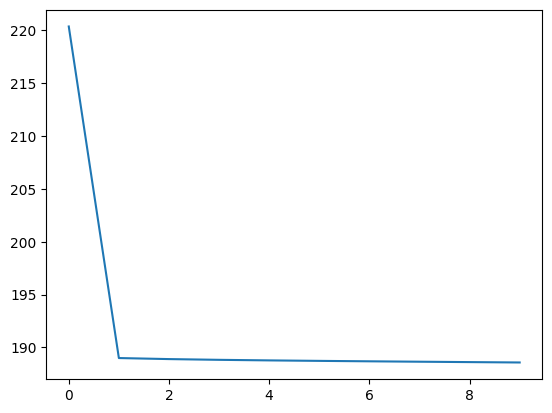

In [13]:
matplotlib.pyplot.plot(history.epoch, history.history['loss'], label='total loss')
matplotlib.pyplot.show()